In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("hf://datasets/DBQ/Farfetch.Product.prices.Macao/data/train-00000-of-00001-e43844630b47de3b.parquet")
df.head()

d:\Projects\BuyBuddy\FreeDuddy-AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,website_name,competence_date,country_code,currency_code,brand,category1_code,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,full_price_eur,price_eur,flg_discount
0,Farfetch,2023-11-17,MAC,HKD,PESERICO,CLOTHING,KNITS,KNITTED SWEATERS,21755241,cable-knit wool-blend polo jumper,http://www.farfetch.com/mo/shopping/women/pese...,https://cdn-images.farfetch-contents.com/21/75...,4727.0,4727.0,558.81,558.81,0
1,Farfetch,2023-11-17,MAC,HKD,PHILOSOPHY DI LORENZO SERAFINI,CLOTHING,DRESSES,EVENING DRESSES,19535310,pattern-print short-sleeve gown,http://www.farfetch.com/mo/shopping/women/phil...,https://cdn-images.farfetch-contents.com/19/53...,9038.0,5423.0,1068.44,641.09,1
2,Farfetch,2023-11-17,MAC,HKD,ALEMAIS,CLOTHING,DRESSES,DAY DRESSES,20192671,Elisabetta floral-print linen minidress,http://www.farfetch.com/mo/shopping/women/alem...,https://cdn-images.farfetch-contents.com/20/19...,3821.0,3821.0,451.70,451.70,0
3,Farfetch,2023-11-17,MAC,HKD,MOSCHINO KIDS,BABY GIRL CLOTHING,TOPS,BABY T-SHIRTS,20919312,logo-print cotton T-shirt,http://www.farfetch.com/mo/shopping/kids/mosch...,https://cdn-images.farfetch-contents.com/20/91...,919.0,919.0,108.64,108.64,0
4,Farfetch,2023-11-17,MAC,HKD,PAULA,CLOTHING,TOPS,T-SHIRTS & JERSEY SHIRTS,18003736,stripe-print linen T-shirt,http://www.farfetch.com/mo/shopping/women/paul...,https://cdn-images.farfetch-contents.com/18/00...,820.0,820.0,96.93,96.93,0


In [3]:
df.shape

(587981, 17)

In [4]:
import os
import hashlib
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
from tqdm import tqdm

In [5]:
output_dir = 'images'
os.makedirs(output_dir, exist_ok=True)

In [ ]:

# Reuse session for efficiency
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/139.0.0.0 Safari/537.36"
})

def download_image(idx, url, retries=3, delay=2):
    """Download one image with retry logic and error logging."""
    try:
        ext = url.split('.')[-1].split('?')[0] if '.' in url else 'jpg'
        filename = hashlib.md5(url.encode()).hexdigest() + f".{ext}"
        filepath = os.path.join(output_dir, filename)

        # Skip if already exists
        if os.path.exists(filepath):
            return idx, filepath, None

        for attempt in range(retries):
            try:
                with session.get(url, stream=True, timeout=15) as r:
                    r.raise_for_status()
                    with open(filepath, "wb") as f:
                        for chunk in r.iter_content(chunk_size=8192):
                            f.write(chunk)
                return idx, filepath, None  # success
            except Exception as e:
                if attempt < retries - 1:
                    time.sleep(delay)  # wait before retry
                else:
                    return idx, None, f"Error ({type(e).__name__}): {e}"

    except Exception as e:
        return idx, None, f"Fatal error: {e}"

# Prepare URLs
urls_with_index = list(enumerate(df["imageurl"]))

# Run threaded download
max_workers = 50
results = []
errors = []

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(download_image, idx, url) for idx, url in urls_with_index]

    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading images"):
        idx, filepath, error = future.result()
        if filepath:
            df.at[idx, "local_image_path"] = filepath
        if error:
            errors.append((idx, df.loc[idx, "imageurl"], error))

# Save updated DataFrame
df.to_csv("updated_dataset.csv", index=False)

print(f"✅ Downloaded {df['local_image_path'].notna().sum()}/{len(df)} images")
if errors:
    print(f"❌ {len(errors)} errors. First few:\n", errors[:5])
    pd.DataFrame(errors, columns=["index", "url", "error"]).to_csv("failed_downloads.csv", index=False)

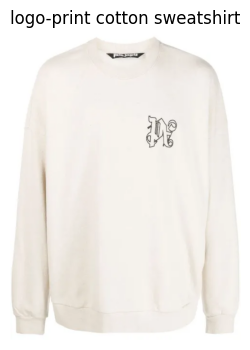

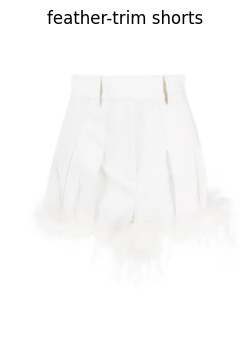

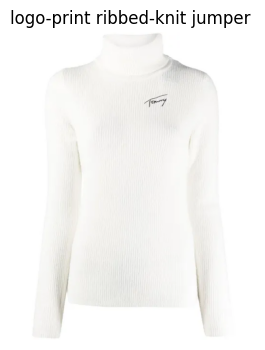

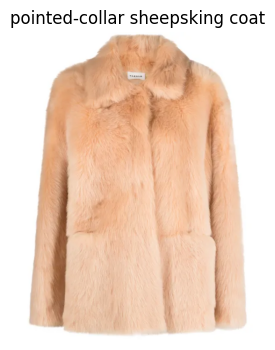

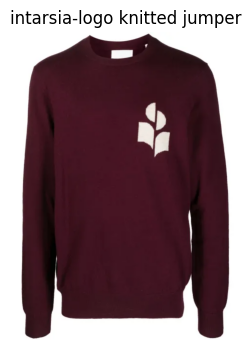

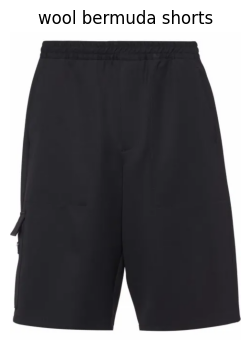

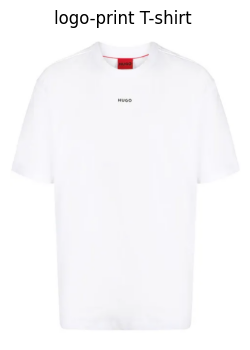

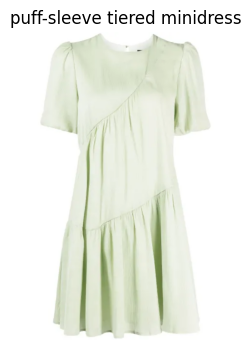

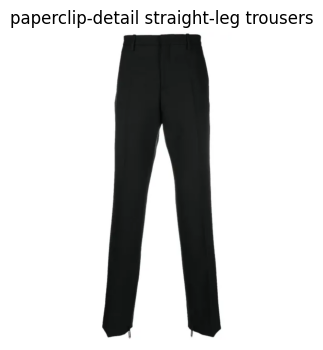

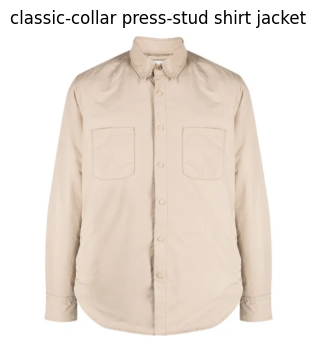

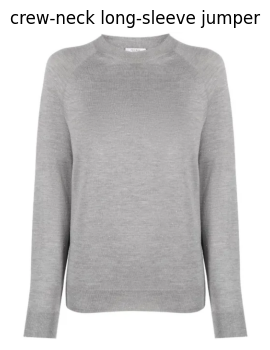

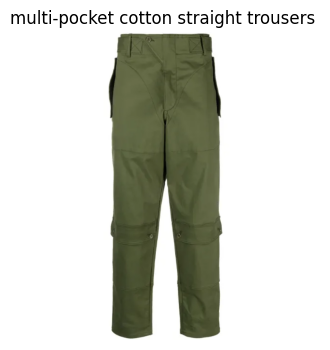

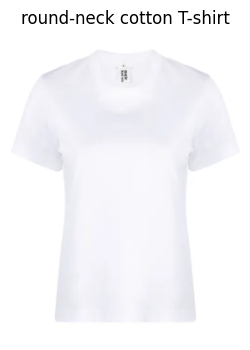

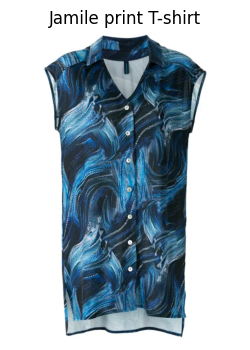

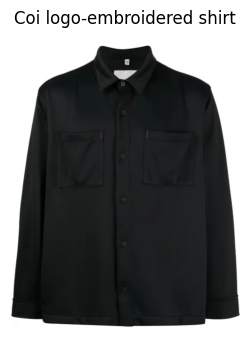

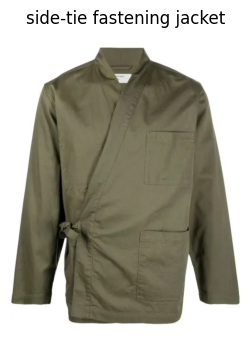

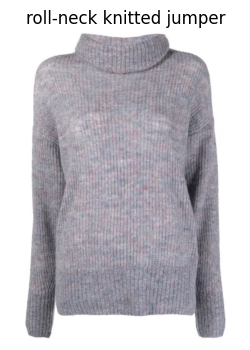

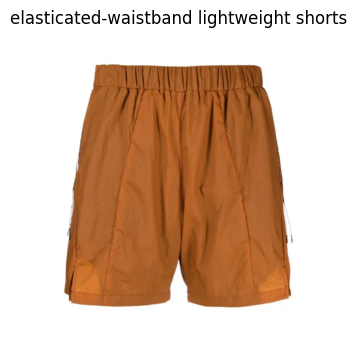

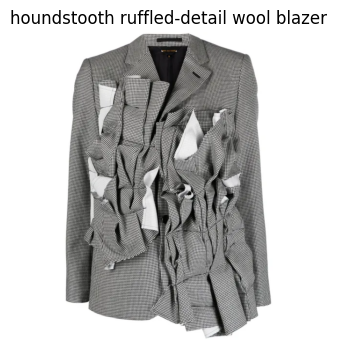

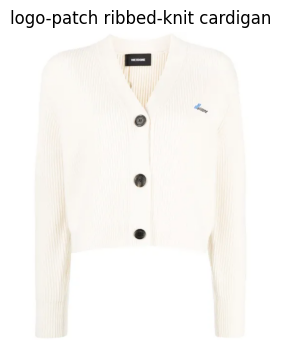

In [92]:
import matplotlib.pyplot as plt
import cv2
import os

samples = tempdf.sample(20, random_state=42)

# Show them
for i, row in samples.iterrows():
    img_path = row['local_image_path']
    
    if os.path.exists(img_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(row["title"])
        plt.show()

In [93]:
tempdf.columns

Index(['index', 'website_name', 'competence_date', 'country_code',
       'currency_code', 'brand', 'category1_code', 'category2_code',
       'category3_code', 'product_code', 'title', 'itemurl', 'imageurl',
       'full_price', 'price', 'full_price_eur', 'price_eur', 'flg_discount',
       'local_image_path'],
      dtype='object')

In [105]:
cols = ['index', 'website_name', 'competence_date', 'brand', 'category2_code',
       'category3_code', 'product_code', 'title', 'itemurl', 'imageurl',
       'full_price', 'price', 'flg_discount',
       'local_image_path']
tempdf = tempdf[cols]

In [106]:
from sklearn.cluster import KMeans
import numpy as np

In [107]:
def hkd_to_usd(price_hkd, rate=0.128):
    return price_hkd * rate

In [108]:
tempdf['full_price'] = tempdf['full_price'].apply(hkd_to_usd)
tempdf['price'] = tempdf['price'].apply(hkd_to_usd)

In [109]:
category_col = "category2_code"
price_col = "price"

def cluster_prices(group):
    # reshape الأسعار لشكل 2D علشان KMeans
    prices = group[price_col].values.reshape(-1, 1)
    
    # لو الكاتيجوري فيها أقل من 3 منتجات، نصنفهم كلهم كـ "متوسط"
    if len(prices) < 3:
        return pd.Series(["mid"] * len(prices), index=group.index)
    
    # KMeans بـ 3 clusters
    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(prices)
    
    # ترتيب الكلاسترز حسب المتوسط علشان نخليها (0=رخيص، 1=متوسط، 2=فاخر)
    cluster_order = np.argsort(kmeans.cluster_centers_.flatten())
    label_map = {cluster_order[0]: "cheap", 
                 cluster_order[1]: "mid", 
                 cluster_order[2]: "luxury"}
    
    return pd.Series([label_map[l] for l in labels], index=group.index)

In [110]:
tempdf["price_category"] = tempdf.groupby(category_col, group_keys=False).apply(cluster_prices)

/tmp/ipykernel_73023/3845189650.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tempdf["price_category"] = tempdf.groupby(category_col, group_keys=False).apply(cluster_prices)


In [111]:
tempdf.head()

,index,website_name,competence_date,brand,category2_code,category3_code,product_code,title,itemurl,imageurl,full_price,price,flg_discount,local_image_path,price_category
100000,100000,Farfetch,2023-11-17,MARQUES'ALMEIDA,DRESSES,DAY DRESSES,19908319,Graffiti-print ruched mesh dress,http://www.farfetch.com/mo/shopping/women/marq...,https://cdn-images.farfetch-contents.com/19/90...,493.056,493.056,0,images/d19bc46963b0a3cba3b8bdf3cb2d0b67.jpg,cheap
100001,100001,Farfetch,2023-11-17,VALENTINO GARAVANI,PANTS,REGULAR-FIT & STRAIGHT LEG PANTS,19660972,Rockstud-embellished cargo trousers,http://www.farfetch.com/mo/shopping/men/valent...,https://cdn-images.farfetch-contents.com/19/66...,2150.400,1290.240,1,images/b32e184205b900e69ff0586c85d79181.jpg,mid
100002,100002,Farfetch,2023-11-17,ELISABETTA FRANCHI,KNITS,KNITTED TOPS,21506295,roll neck crop top,http://www.farfetch.com/mo/shopping/women/elis...,https://cdn-images.farfetch-contents.com/21/50...,457.088,457.088,0,images/1fa7514996addde09e74b1839c51aa22.jpg,cheap
100003,100003,Farfetch,2023-11-17,CASHMERE IN LOVE,KNITS,KNITTED TROUSERS,12255754,cashmere Candiss flared knit trousers,http://www.farfetch.com/mo/shopping/women/cash...,https://cdn-images.farfetch-contents.com/12/25...,327.168,327.168,0,images/2bb91b55057cf2b16089e3e57c4a9708.jpg,cheap
100004,100004,Farfetch,2023-11-17,HACKETT,POLO SHIRTS,NaN,20191459,logo-embroidered cotton polo shirt,http://www.farfetch.com/mo/shopping/men/hacket...,https://cdn-images.farfetch-contents.com/20/19...,196.864,196.864,0,images/733796a55e7e83826c18a5c07d339b5e.jpg,cheap
